# **Import Library**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
from tqdm import tqdm
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from gensim.models import Phrases, LdaModel, LdaMulticore, CoherenceModel
from gensim.corpora import Dictionary
from sklearn.datasets import fetch_20newsgroups
import pyLDAvis
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.cluster import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from umap import UMAP
from sentence_transformers import SentenceTransformer
from collections import Counter
from wordcloud import WordCloud
from matplotlib.colors import LinearSegmentedColormap
from gensim import corpora
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import os
import pickle
import torch

# **Data Loading**

In [2]:
url = "https://storage.googleapis.com/adsp-nlp-open/data/nlp_a_6_news.json"
news_df = pd.read_json(url, orient="records", lines=True).sample(n=5000, random_state=0)

In [3]:
print(f'Shape: {news_df.shape}')
print(f'Columns: {news_df.columns}')

Shape: (5000, 5)
Columns: Index(['url', 'date', 'language', 'title', 'text'], dtype='object')


In [4]:
news_df.head()

,url,date,language,title,text
3844,https://www.kxii.com/prnewswire/2022/05/23/com...,2022-05-23,en,COMPUTEX 2022 Global Press Conference Industry...,COMPUTEX 2022 Global Press Conference Industry...
3617,https://www.bigrapidsnews.com/business/article...,2022-06-09,en,"Moderna, Roku rise; Scotts Miracle-Gro, Charle...","Moderna, Roku rise; Scotts Miracle-Gro, Charle..."
2608,https://www.devdiscourse.com/article/education...,2022-04-12,en,Create entrepreneurship ecosystem in districts...,Create entrepreneurship ecosystem in districts...
3857,https://www.seattletimes.com/seattle-news/heal...,2022-04-30,en,Connecticut Senate OKs bill that protects abor...,Connecticut Senate OKs bill that protects abor...
1595,https://www.breakinglatest.news/news/maturity-...,2022-07-24,en,"Maturity, thanks from Fabio and Adriana: “Incl...","Maturity, thanks from Fabio and Adriana: “Incl..."


In [5]:
news_df['combined_text'] = news_df['title'] + " " + news_df['text']

# **Exploratory Data Analysis**

In [6]:
# Light cleaning: Remove extra whitespace and duplicate punctuation/characters
def light_clean_text(text):
    if pd.isnull(text):  # handle NaNs gracefully
        return ""
    text = re.sub(r"(\s)+", " ", text) # Replace multiple spaces with a single space
    text = re.sub(r"([^a-zA-Z0-9])\1+", r"\1", text) # Remove repeated punctuation
    return text.strip()

In [7]:
news_df['combined_light_cleaned'] = news_df['combined_text'].apply(light_clean_text)

In [8]:
def plot_word_count(text_distribution, plot_title):
    plt.figure(figsize= (8,5))
    sns.histplot(text_distribution, kde= True)
    plt.title(plot_title, fontweight= 'bold', fontsize= 16)
    plt.xlabel('Text Length', fontweight= 'bold')
    plt.ylabel('Count', fontweight= 'bold')
    plt.show()

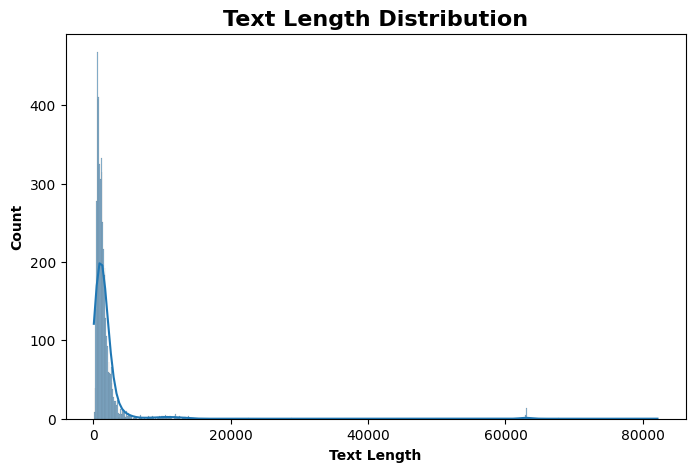

In [9]:
# Number of words in each document after light cleaning
news_df['text_length'] = news_df['combined_light_cleaned'].str.split().str.len()

plot_word_count(news_df['text_length'], 'Text Length Distribution')

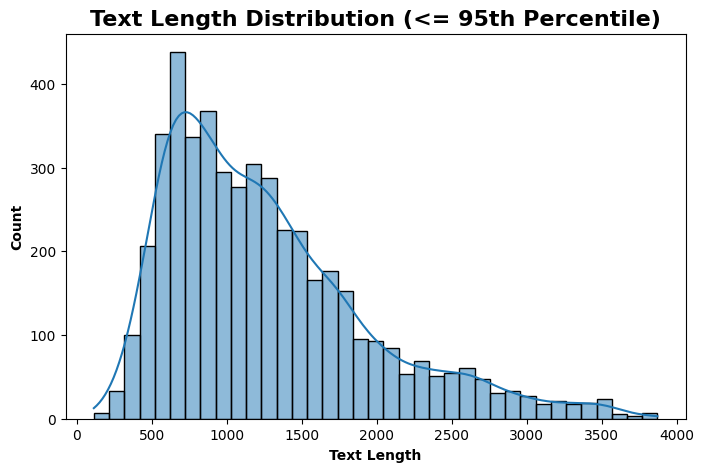

In [10]:
cutoff = np.percentile(news_df['text_length'], 95)
shortened_lengths = news_df[news_df['text_length'] <= cutoff]['text_length']

plot_word_count(shortened_lengths, 'Text Length Distribution (<= 95th Percentile)')

In [11]:
news_df = news_df[news_df['text_length'] <= cutoff]
print(f'Shape: {news_df.shape}')

Shape: (4750, 8)


In [12]:
# Type-to-Token Ratio (TTR) as a measure of lexical diversity (can help identify excessive repition).
def calc_ttr(text: str) -> float:
    words = text.split()
    unique_words = len(set(words))
    total_words = len(words)
    return unique_words / total_words if total_words > 0 else 0

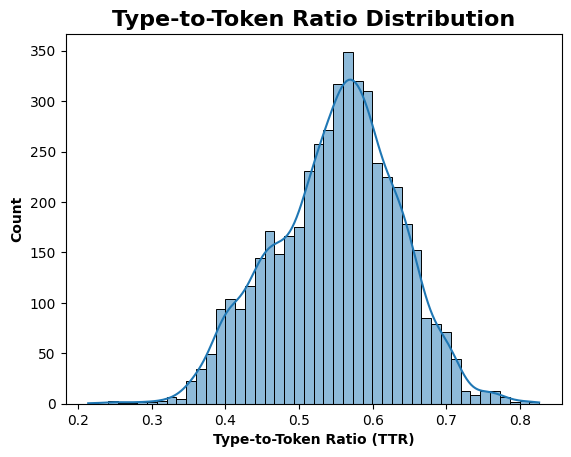

In [13]:
# Apply the TTR function to the light-cleaned text
news_df['ttr'] = news_df['combined_light_cleaned'].apply(calc_ttr)

sns.histplot(news_df['ttr'], kde= True)
plt.title('Type-to-Token Ratio Distribution', fontweight= 'bold', fontsize= 16)
plt.xlabel('Type-to-Token Ratio (TTR)', fontweight= 'bold')
plt.ylabel('Count', fontweight= 'bold')
plt.show()

In [14]:
# Vectorize with unigrams and bigrams
vectorizer = CountVectorizer(max_features= 1000, stop_words= 'english', ngram_range= (1, 2))
X = vectorizer.fit_transform(news_df['combined_text'])

# Get vocab and word counts
word_freq = X.sum(axis=0).A1
vocab = vectorizer.get_feature_names_out()

# Create frequency DataFrame
freq_df = pd.DataFrame({'ngram': vocab, 'count': word_freq})
freq_df['ngram_size'] = freq_df['ngram'].apply(lambda x: len(x.split()))

# Separate unigrams and bigrams
unigram_df = freq_df[freq_df['ngram_size'] == 1].sort_values(by='count', ascending=False).reset_index(drop=True)
bigram_df = freq_df[freq_df['ngram_size'] == 2].sort_values(by='count', ascending=False).reset_index(drop=True)

# Combine into one DataFrame
combined_df = pd.DataFrame({
    'Unigram': unigram_df['ngram'],
    'Unigram Count': unigram_df['count'],
    'Bigram': bigram_df['ngram'],
    'Bigram Count': bigram_df['count'],
})

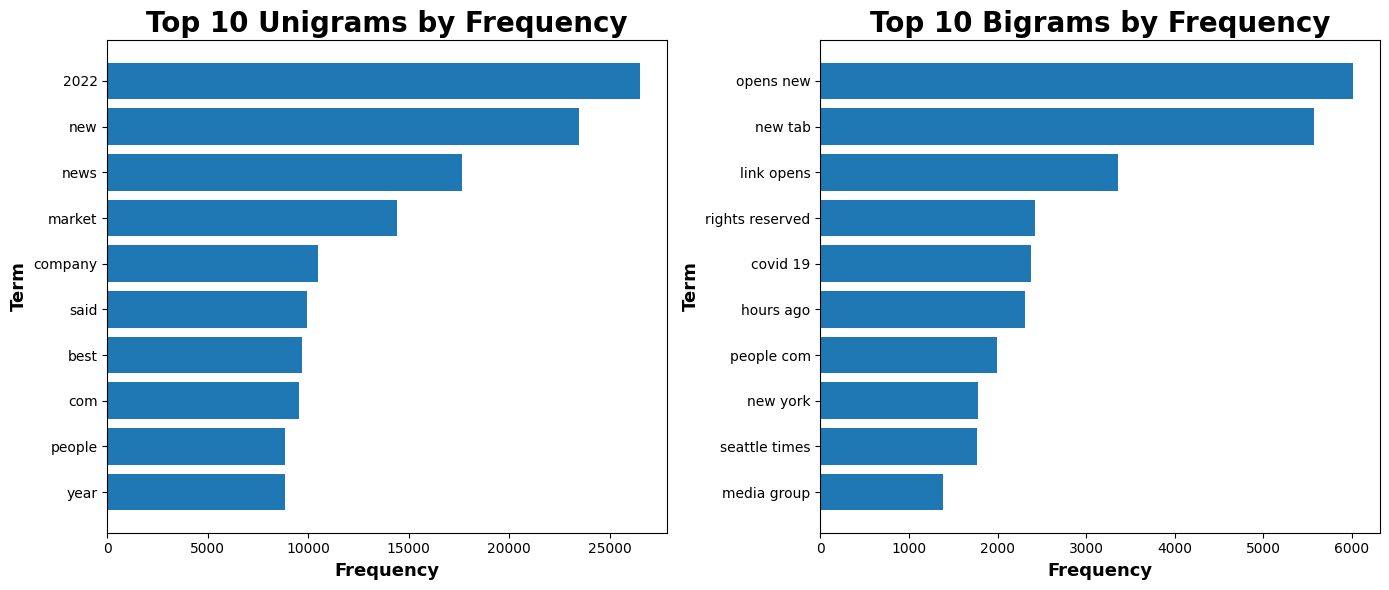

In [15]:
plot_df = combined_df.dropna().head(10)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot Unigrams
axes[0].barh(plot_df['Unigram'], plot_df['Unigram Count'])
axes[0].set_title('Top 10 Unigrams by Frequency', fontsize= 20, fontweight= 'bold')
axes[0].invert_yaxis()
axes[0].set_ylabel('Term', fontsize= 13, fontweight= 'bold')
axes[0].set_xlabel('Frequency', fontsize= 13, fontweight= 'bold')

# Plot Bigrams
axes[1].barh(plot_df['Bigram'], plot_df['Bigram Count'])
axes[1].set_title('Top 10 Bigrams by Frequency', fontsize= 20, fontweight= 'bold')
axes[1].invert_yaxis()
axes[1].set_ylabel('Term', fontsize= 13, fontweight= 'bold')
axes[1].set_xlabel('Frequency', fontsize= 13, fontweight= 'bold')

plt.tight_layout()
plt.show()

In [16]:
# Vectorize using TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    max_features= 3000, 
    stop_words= 'english', 
    ngram_range= (1, 3)
)
X_tfidf = tfidf_vectorizer.fit_transform(news_df['combined_text'])

# Get average TF-IDF scores
vocab = tfidf_vectorizer.get_feature_names_out()
avg_tfidf_scores = X_tfidf.mean(axis= 0).A1

# Create dataframe
tfidf_df = pd.DataFrame({
    'term': vocab, 
    'avg_tfidf': avg_tfidf_scores 
})

# Get the top 20 scores
top_terms = tfidf_df.sort_values(by= 'avg_tfidf', ascending= False).head(20)
top_terms_sorted = top_terms.sort_values(by= 'avg_tfidf')

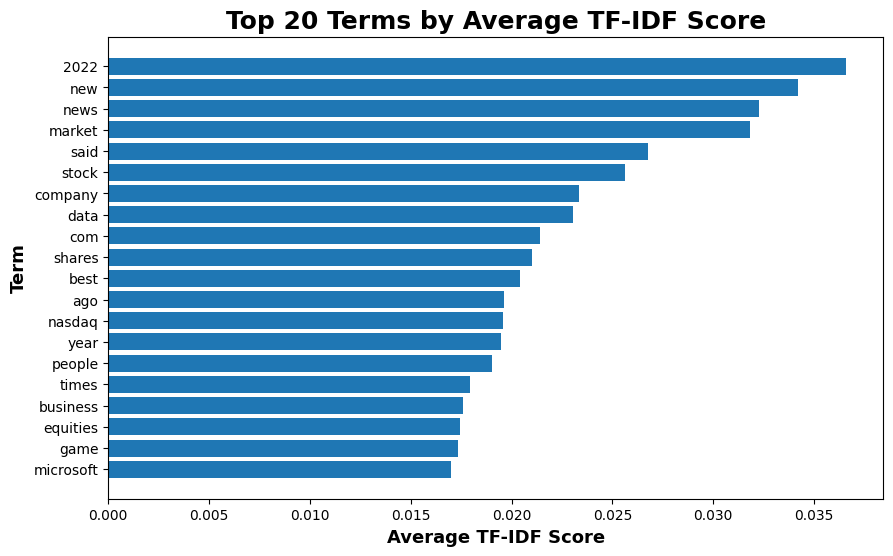

In [17]:
# Plot the the top 20 terms
plt.figure(figsize=(10, 6))
plt.barh(top_terms_sorted['term'], top_terms_sorted['avg_tfidf'])
plt.xlabel('Average TF-IDF Score', fontweight= 'bold', fontsize= 13)
plt.ylabel('Term', fontweight= 'bold', fontsize= 13)
plt.title('Top 20 Terms by Average TF-IDF Score', fontsize= 18, fontweight= 'bold')
plt.show()

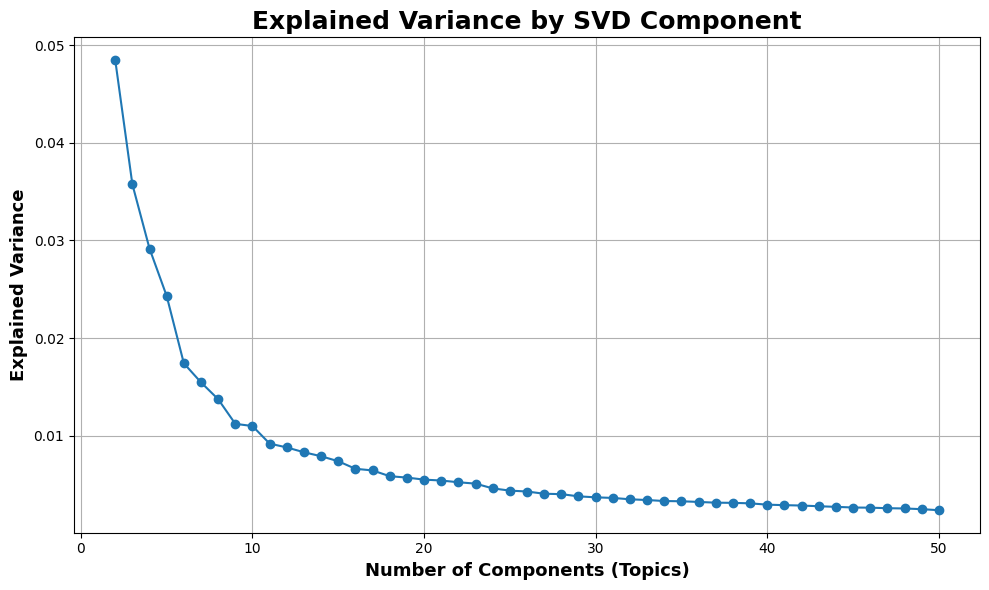

In [18]:
# Set topic upper bound
n_components = 50

# Decompose by each number of components (topics)
svd = TruncatedSVD(n_components= n_components)
svd.fit(X_tfidf)

# Record the explained variance
explained_var = svd.explained_variance_ratio_

# Plot the explained variance by component (topic)
plt.figure(figsize= (10, 6))
plt.plot(range(2, n_components + 1), explained_var[1:], marker= 'o')
plt.title('Explained Variance by SVD Component', fontsize= 18, fontweight= 'bold')
plt.xlabel('Number of Components (Topics)', fontsize= 13, fontweight= 'bold')
plt.ylabel('Explained Variance', fontsize= 13, fontweight= 'bold')
plt.grid(True)
plt.tight_layout()
plt.show()

# **Model Preprocessing**

In [19]:
def heavy_clean_text(corpus, spacy_pipeline, as_string=True, batch_size=500):
    """
    Cleans a sequence of text by applying simple processing techniques in batches with progress tracking.

    Args:
        corpus (Iterable): a sequence of text to be processed
        spacy_pipeline: the Spacy pipeline object for processing text
        as_string (bool): whether to return the cleaned tokens as joined strings or lists
        batch_size (int): number of documents to process per batch

    Returns:
        clean_sequence (list): a cleaned version of the original text
    """
    corpus_clean = []
    total_batches = (len(corpus) + batch_size - 1) // batch_size  # ceiling division

    for i in tqdm(range(0, len(corpus), batch_size), desc="Cleaning text (batches)", total=total_batches):
        batch = corpus[i:i + batch_size]

        try:
            docs = list(spacy_pipeline.pipe(
                batch,
                disable=["ner"],
                n_process=1  # safer for Mac/Jupyter
            ))

            for doc in tqdm(docs, desc=f"Processing batch {i // batch_size + 1}", leave=False):
                doc_tokens = [
                    token.lemma_.lower()
                    for token in doc
                    if not token.is_stop and token.is_alpha and len(token) > 1 and token.pos_ in ("NOUN", "VERB")
                ]

                if as_string:
                    corpus_clean.append(" ".join(doc_tokens))
                else:
                    corpus_clean.append(doc_tokens)

        except Exception as e:
            print(f"\nError processing batch {i // batch_size + 1}: {e}")
            continue

    return corpus_clean

In [20]:
# loading spacy model
nlp = spacy.load("en_core_web_md")

In [21]:
# Filepath to save/load the normalized_corpus
normalized_corpus_filepath = "normalized_corpus.pkl"

# Check if the file exists
if os.path.exists(normalized_corpus_filepath):
    print("Loading normalized_corpus from file...")
    with open(normalized_corpus_filepath, "rb") as file:
        normalized_corpus = pickle.load(file)
else:
    print("File not found. Running heavy_clean_text...")
    # Run the heavy_clean_text function
    normalized_corpus = heavy_clean_text(
        corpus=news_df['combined_light_cleaned'].tolist(),
        spacy_pipeline=nlp,
        as_string=False
    )
    # Save the result to a file
    print("Saving normalized_corpus to file...")
    with open(normalized_corpus_filepath, "wb") as file:
        pickle.dump(normalized_corpus, file)

# normalized_corpus is now ready to use
print("normalized_corpus is ready.")

Loading normalized_corpus from file...
normalized_corpus is ready.


In [22]:
normalized_corpus[1]

['rise',
 'fall',
 'rise',
 'fall',
 'content',
 'rise',
 'sportsopinioncolumnsletter',
 'estatearchiveseventsclassifiedsadvertisecontacte',
 'update',
 'suspect',
 'assault',
 'cooperate',
 'authority',
 'got',
 'snake',
 'racer',
 'snake',
 'report',
 'way',
 'end',
 'season',
 'penalty',
 'haunt',
 'restaurant',
 'restaurant',
 'car',
 'crash',
 'official',
 'assemble',
 'emergency',
 'exercise',
 'sophomore',
 'make',
 'claim',
 'sprinter',
 'circuit',
 'judge',
 'retire',
 'year',
 'rise',
 'falljune',
 'stock',
 'trade',
 'price',
 'change',
 'lawn',
 'garden',
 'care',
 'company',
 'slash',
 'profit',
 'forecast',
 'year',
 'cent',
 'maker',
 'can',
 'soup',
 'cookie',
 'raise',
 'revenue',
 'forecast',
 'year',
 'maker',
 'signature',
 'technology',
 'announce',
 'expand',
 'partnership',
 'drugmaker',
 'say',
 'vaccine',
 'combine',
 'shoot',
 'protection',
 'variant',
 'appear',
 'work',
 'maker',
 'datum',
 'storage',
 'device',
 'say',
 'review',
 'option',
 'separate',
 'f

In [23]:
news_df.combined_text.iloc[1]

"Moderna, Roku rise; Scotts Miracle-Gro, Charles River fall Moderna, Roku rise; Scotts Miracle-Gro, Charles River fall        Skip to main content Big Rapids Pioneer HomepageCurrently ReadingModerna, Roku rise; Scotts Miracle-Gro, Charles River fallSubscribeSubscribee-EditionSign In  homeFormsNewslettersPuzzlesNewsCoronavirusLocal NewsHeroes UnmaskedState NewsSpecial SectionsSportsLocal SportsFerris SportsState SportsOpinionColumnsLetters to the EditorObituariesSubmit an ObituaryCoronavirusCannabisPhotosWeatherReal EstateArchivesEventsClassifiedsAdvertiseContactE-EditionSubscriber Services   Most Popular Update: Suspect in assault ID'd, cooperating with authorities Got snakes? Blue racer snakes reported in Mecosta County Tough way to end the season: Penalty kicks haunt Big Rapids Michigan restaurants that have been on 'Restaurant: Impossible' Two dead in three-car crash in Grand Rapids Midland County officials assemble for emergency exercise Chippewa Hills sophomore makes her claim as 

In [24]:
min_counts = np.insert(np.arange(5, 50, 5), 0, 2)
bigram_counts = []

for mc in min_counts:
    phraser = Phrases(normalized_corpus, min_count=mc)
    count = sum(1 for doc in phraser[normalized_corpus] for token in doc if '_' in token)
    bigram_counts.append(count)

In [25]:
bigram_counts

[279383,
 219365,
 178615,
 157106,
 144184,
 133097,
 123012,
 115836,
 110024,
 105378]

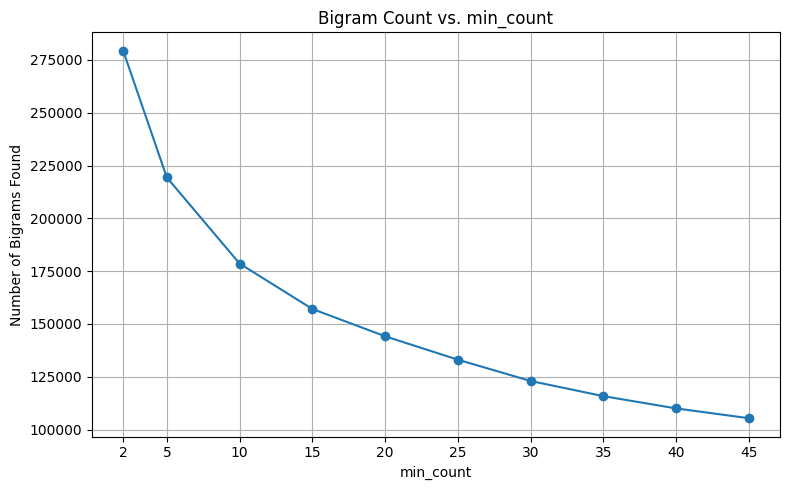

In [26]:
plt.figure(figsize=(8, 5))
plt.plot(min_counts, bigram_counts, marker='o', linestyle='-')
plt.title('Bigram Count vs. min_count')
plt.xlabel('min_count')
plt.ylabel('Number of Bigrams Found')
plt.grid(True)
plt.xticks(min_counts)
plt.tight_layout()
plt.show()

In [27]:
# training the phrases to find bigrams
bigram_phraser = Phrases(
    normalized_corpus,
    min_count= 10)

# adding bigrams to the original unigram data
for idx in range(len(normalized_corpus)):
    for phrase in bigram_phraser[normalized_corpus[idx]]:
        if '_' in phrase:
            # phrase is a bigram, add to document.
            normalized_corpus[idx].append(phrase)

In [28]:
# a dictiohary is the mapping of an id to a word
dictionary = Dictionary(normalized_corpus)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=0.01*len(normalized_corpus), no_above=0.5)

In [29]:
[(token, idx) for token, idx in dictionary.token2id.items()][:10]

[('accelerate', 0),
 ('achieve', 1),
 ('adapt', 2),
 ('addition', 3),
 ('address', 4),
 ('adopt', 5),
 ('advantage', 6),
 ('agreement', 7),
 ('aim', 8),
 ('allow', 9)]

In [30]:
corpus = [dictionary.doc2bow(doc) for doc in normalized_corpus]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 3474
Number of documents: 4750


# **Topic Modeling**

Here is where we will apply two approaches to topic modeling & identification: LDA and BERTopic.

## LDA Topic Modeling

### Inital Model

In [31]:
num_topics = 5
chunksize = 10 
passes = 20 
iterations = 400 
eval_every = 0 

model = LdaModel(
    corpus= corpus,
    id2word= dictionary,
    chunksize= chunksize,
    alpha="auto",
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every,
    random_state= 42
)

In [32]:
model.show_topics()

[(0,
  '0.018*"market" + 0.012*"provide" + 0.012*"use" + 0.011*"product" + 0.010*"datum" + 0.008*"business" + 0.008*"technology" + 0.007*"growth" + 0.007*"user" + 0.007*"industry"'),
 (1,
  '0.029*"buy" + 0.022*"rate" + 0.021*"analyst" + 0.020*"rating" + 0.014*"inflation" + 0.013*"report" + 0.013*"sale" + 0.011*"trade" + 0.010*"acquire" + 0.010*"own"'),
 (2,
  '0.046*"open" + 0.036*"link" + 0.031*"tab" + 0.018*"email" + 0.016*"link_open" + 0.012*"open_tab" + 0.012*"podcast" + 0.011*"window" + 0.010*"account" + 0.010*"profile"'),
 (3,
  '0.026*"share" + 0.022*"stock" + 0.021*"price" + 0.013*"sell" + 0.010*"quarter" + 0.009*"deal" + 0.009*"want" + 0.008*"week" + 0.007*"rise" + 0.007*"know"'),
 (4,
  '0.011*"pm" + 0.010*"hour" + 0.010*"come" + 0.009*"game" + 0.007*"tv" + 0.007*"need" + 0.007*"right" + 0.006*"post" + 0.006*"go" + 0.006*"search"')]

In [33]:
# Prepare the visualization
vis_data = gensimvis.prepare(model, corpus, dictionary)

# display
pyLDAvis.display(vis_data)

### Hyperparameter Tuning

In [ ]:
def evaluate_lda_models_with_coherence(dtm, texts, topic_range, vectorizer):
    """
    Evaluate LDA models using both perplexity and coherence scores.
    
    Parameters:
    - dtm: Document-Term Matrix
    - texts: Tokenized texts (list of list of tokens)
    - topic_range: Range of topic numbers to evaluate
    - vectorizer: The CountVectorizer used to generate dtm
    
    Returns:
    - perplexity_scores: list of perplexity values
    - coherence_scores: list of coherence values
    """
    perplexity_scores = []
    coherence_scores = []

    # Create Gensim dictionary and corpus
    vocab = vectorizer.get_feature_names_out()
    id2word = dict((id, word) for word, id in vectorizer.vocabulary_.items())
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    for n_topics in topic_range:
        print(f"Evaluating LDA with {n_topics} topics...")

        # Fit sklearn LDA
        lda = LatentDirichletAllocation(
            n_components=n_topics,
            max_iter=20,
            learning_method='online',
            random_state=42,
            n_jobs=-1
        )
        lda.fit(dtm)

        # Perplexity
        perplexity = lda.perplexity(dtm)
        perplexity_scores.append(perplexity)

        # Convert sklearn LDA to Gensim-compatible format
        topics = []
        for topic_idx, topic in enumerate(lda.components_):
            top_words = topic.argsort()[:-11:-1]
            topics.append([vocab[i] for i in top_words])

        # Coherence
        cm = CoherenceModel(
            topics=topics,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence = cm.get_coherence()
        coherence_scores.append(coherence)

        print(f"  Perplexity: {perplexity:.2f} | Coherence: {coherence:.4f}")

    return perplexity_scores, coherence_scores

Evaluating LDA with 5 topics...
  Perplexity: 970.88 | Coherence: 0.4657
Evaluating LDA with 10 topics...
  Perplexity: 801.05 | Coherence: 0.5196
Evaluating LDA with 15 topics...
  Perplexity: 723.59 | Coherence: 0.5299
Evaluating LDA with 20 topics...
  Perplexity: 728.67 | Coherence: 0.5505
Evaluating LDA with 25 topics...
  Perplexity: 676.15 | Coherence: 0.5545
Evaluating LDA with 30 topics...
  Perplexity: 662.38 | Coherence: 0.5254


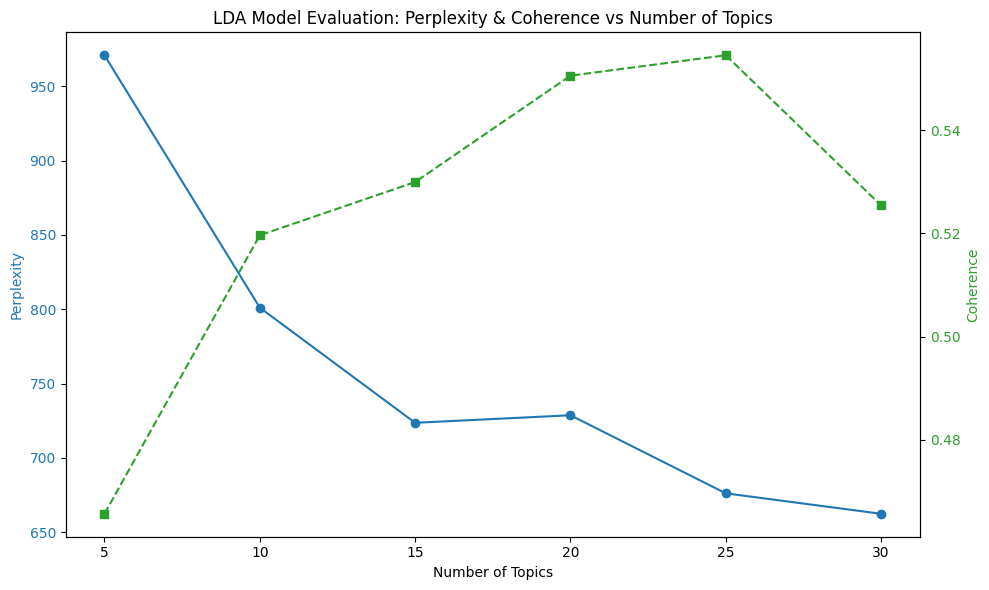

In [35]:
# Define the range of topics to evaluate
topic_range = range(5, 31, 5)

# Define the vectorizer
vectorizer = CountVectorizer(
	stop_words="english", 
	ngram_range=(1, 2),
	min_df=5,
	max_df=0.9,
	max_features=3000
)


# Create the Document-Term Matrix (dtm)
dtm = vectorizer.fit_transform([" ".join(doc) for doc in normalized_corpus])

# Call the evaluation function
perplexity_scores, coherence_scores = evaluate_lda_models_with_coherence(dtm, normalized_corpus, topic_range, vectorizer)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Perplexity', color=color)
ax1.plot(topic_range, perplexity_scores, marker='o', color=color, label='Perplexity')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for coherence
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Coherence', color=color)
ax2.plot(topic_range, coherence_scores, marker='s', linestyle='--', color=color, label='Coherence')
ax2.tick_params(axis='y', labelcolor=color)

# Titles and legends
plt.title('LDA Model Evaluation: Perplexity & Coherence vs Number of Topics')
fig.tight_layout()
plt.show()

20 topics is the optimal choice based on the peak coherence and sufficiently low perplexity.

In [36]:
num_topics = 20
chunksize = 10
passes = 20
iterations = 400 
eval_every = 0  

model = LdaModel(
    corpus= corpus,
    id2word= dictionary,
    chunksize= chunksize,
    alpha= 'auto',
    eta= 'auto',
    iterations= iterations,
    num_topics= num_topics,
    passes= passes,
    eval_every= eval_every,
    random_state= 42
)

In [37]:
model.show_topics()

[(1,
  '0.000*"search_shopping" + 0.000*"save_screeneretf" + 0.000*"spark" + 0.000*"sensor" + 0.000*"selection" + 0.000*"trend_activesstock" + 0.000*"screeneretf" + 0.000*"panel" + 0.000*"recession_fear" + 0.000*"affiliate_commission"'),
 (11,
  '0.000*"search_shopping" + 0.000*"save_screeneretf" + 0.000*"spark" + 0.000*"sensor" + 0.000*"selection" + 0.000*"trend_activesstock" + 0.000*"screeneretf" + 0.000*"panel" + 0.000*"recession_fear" + 0.000*"affiliate_commission"'),
 (16,
  '0.000*"search_shopping" + 0.000*"save_screeneretf" + 0.000*"spark" + 0.000*"sensor" + 0.000*"selection" + 0.000*"trend_activesstock" + 0.000*"screeneretf" + 0.000*"panel" + 0.000*"recession_fear" + 0.000*"affiliate_commission"'),
 (14,
  '0.000*"search_shopping" + 0.000*"save_screeneretf" + 0.000*"spark" + 0.000*"sensor" + 0.000*"selection" + 0.000*"trend_activesstock" + 0.000*"screeneretf" + 0.000*"panel" + 0.000*"recession_fear" + 0.000*"affiliate_commission"'),
 (6,
  '0.000*"search_shopping" + 0.000*"save

In [38]:
topic_words = model.show_topic(2, topn=10)
topic_words

[('pm', 0.16874918),
 ('message', 0.06467376),
 ('view', 0.061026134),
 ('account', 0.050221857),
 ('sign', 0.04533153),
 ('password', 0.039651625),
 ('article', 0.03576965),
 ('datum', 0.03489495),
 ('profile', 0.031865034),
 ('send', 0.027660014)]

In [39]:
# Prepare the visualization
vis_data = gensimvis.prepare(model, corpus, dictionary)

# Convert complex numbers to real numbers in the topic coordinates
vis_data.topic_coordinates['x'] = vis_data.topic_coordinates['x'].apply(lambda x: x.real)
vis_data.topic_coordinates['y'] = vis_data.topic_coordinates['y'].apply(lambda x: x.real)

# display
pyLDAvis.display(vis_data)

Generating word clouds for LDA topics...


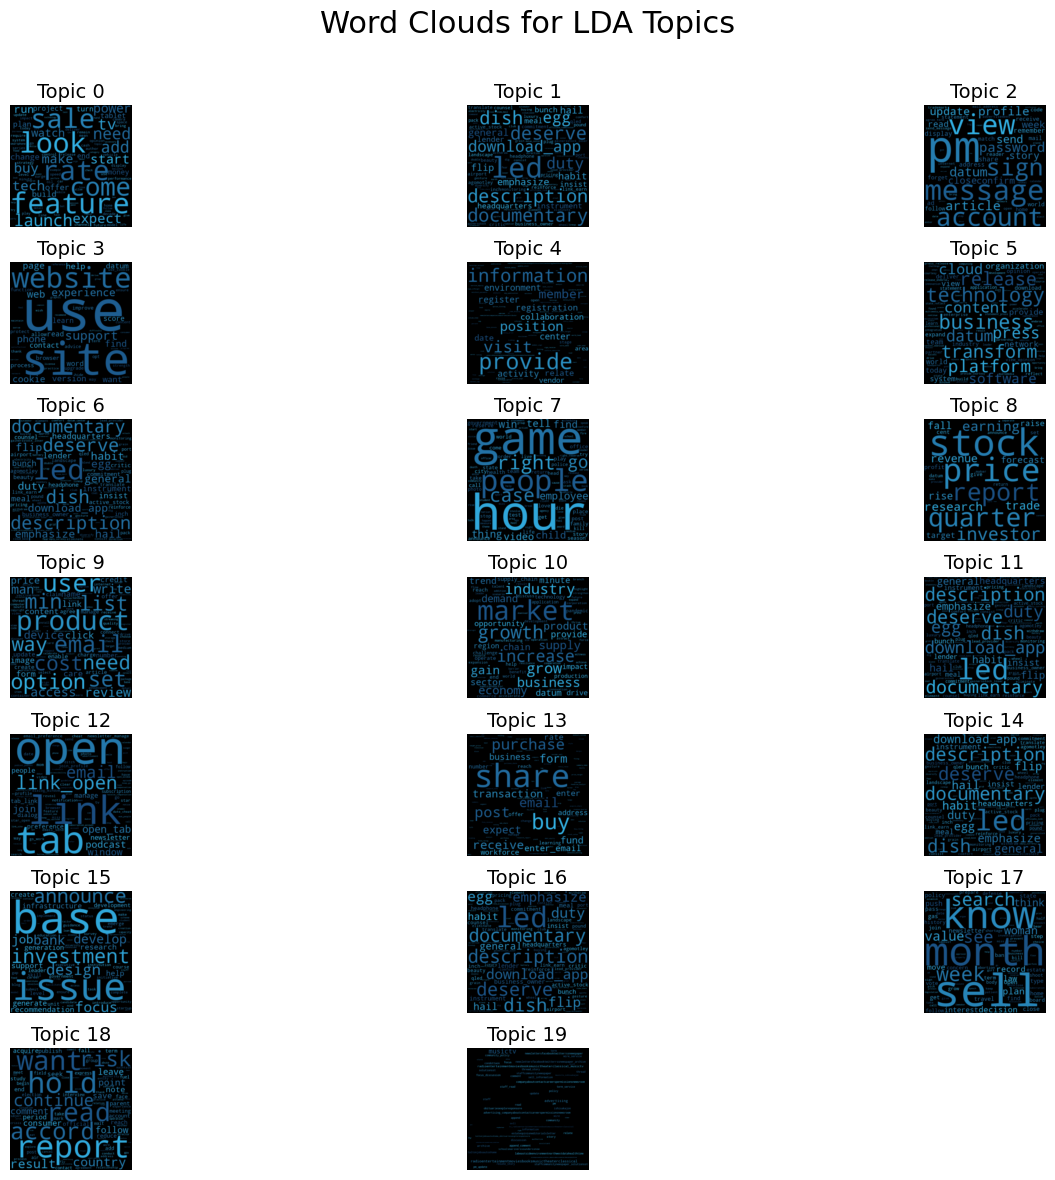

In [40]:
def create_topic_wordclouds(model, id2word, num_topics=None, figsize=(15, 12), cols=3):
    """
    Create word clouds for each topic in the LDA model
    """
    if num_topics is None:
        num_topics = model.num_topics
    
    # Subplot grid
    rows = int(np.ceil(num_topics / cols))
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()
    
    # Colormap for word clouds
    colors = [(0.1, 0.3, 0.5), (0.2, 0.7, 0.9)]
    custom_cmap = LinearSegmentedColormap.from_list('custom_blue', colors)
    
    for i, topic_id in enumerate(range(num_topics)):
        if i >= len(axes):
            break
            
        # Top words for this topic
        topic_words = dict(model.show_topic(topic_id, topn=100))
        
        # Wword cloud
        wc = WordCloud(
            background_color='black',
            colormap=custom_cmap,
            width=400, height=400,
            max_words=100,
            prefer_horizontal=1.0
        )
        wc.generate_from_frequencies(topic_words)
        
        axes[i].imshow(wc, interpolation='bilinear')
        axes[i].set_title(f'Topic {topic_id}', fontsize=14)
        axes[i].axis('off')
    
    # Hidding any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.suptitle('Word Clouds for LDA Topics', fontsize=22)
    return fig

print("Generating word clouds for LDA topics...")
lda_wordcloud_fig = create_topic_wordclouds(model, dictionary)
plt.show()

In [41]:
# Representative documents for each topic
def get_representative_docs_lda(model, corpus, original_texts, top_n=5):
    """
    Find representative documents for each topic
    """
    # Topic distributions for all documents
    doc_topics = [model.get_document_topics(doc) for doc in corpus]
    
    topics_docs = {i: [] for i in range(model.num_topics)}
    
    # For each document we are finding its dominant topic and probability
    for doc_idx, topic_dist in enumerate(doc_topics):
        # Sorting by probability
        sorted_topics = sorted(topic_dist, key=lambda x: x[1], reverse=True)
        dominant_topic = sorted_topics[0][0]
        prob = sorted_topics[0][1]
        
        topics_docs[dominant_topic].append((doc_idx, prob, original_texts[doc_idx]))
    
    # Getting the top_n documents with highest probability for each topic
    representative_docs = {}
    for topic_id, docs in topics_docs.items():
        # Sorting by probability
        sorted_docs = sorted(docs, key=lambda x: x[1], reverse=True)
        # Taking the top_n documents
        representative_docs[topic_id] = [(idx, prob, text) for idx, prob, text in sorted_docs[:top_n]]
    
    return representative_docs

def display_representative_docs_lda(representative_docs, topics_words=None, num_topics=None):
    if num_topics is None:
        num_topics = len(representative_docs)
    
    for topic_id in range(min(num_topics, len(representative_docs))):
        print(f"\n{'='*80}\nTOPIC {topic_id}")
        
        # Top words for this topic
        if topics_words and topic_id in topics_words:
            words = topics_words[topic_id]
            print(f"Top words: {', '.join(words)}")
        
        print(f"\nRepresentative documents:")
        docs = representative_docs[topic_id]
        
        for i, (doc_idx, prob, text) in enumerate(docs):
            # Join the list of tokens into a string if necessary
            if isinstance(text, list):
                text = " ".join(text)
            # Truncating very long documents
            display_text = text[:500] + "..." if len(text) > 500 else text
            print(f"\nDocument {i+1} (Doc #{doc_idx}, Topic Probability: {prob:.4f}):")
            print(f"{display_text}")

rep_docs = get_representative_docs_lda(model, corpus, normalized_corpus, top_n=3)

topics_words = {i: [word for word, _ in model.show_topic(i, topn=10)] for i in range(model.num_topics)}

In [42]:
print("\n REPRESENTATIVE DOCUMENTS FOR EACH LDA TOPIC")
display_representative_docs_lda(rep_docs, topics_words)


 REPRESENTATIVE DOCUMENTS FOR EACH LDA TOPIC

TOPIC 0
Top words: feature, look, rate, sale, come, launch, need, add, tv, expect

Representative documents:

Document 1 (Doc #9, Topic Probability: 0.7426):
soc base fabrication cluster setup soc base fabrication cluster setup today tv special opinion technology soc base fabrication cluster setup soc base fabrication cluster setup debut smartphone soc year update pm highlight platform use nm fabrication process soc cpu architecture smartphone soc debut end year launch expect power flagship smartphone world smartphone soc detail successor leak soc chipset accord tipster platform use nm fabrication process chipset cluster setup series claim soc cpu ar...

Document 2 (Doc #530, Topic Probability: 0.6033):
display display feature opinion tv tablet watch laptop tv tablet watch plan deal game tv pc laptop app homemobilesmobile display display launch update feature amoled touchscreen power soc launch event live stream smartphone ram set launch c

### __LDA (Latent Dirichlet Allocation) - Choosing the Number of Topics__
__Evaluation Metrics:__
The number of topics for LDA was chosen based on coherence scores and perplexity. These metrics were calculated for a range of topic numbers (e.g., 5 to 30 topics in increments of 5).

_Coherence Score: Measures the interpretability of topics by evaluating the semantic similarity of top words in each topic._
</br>_Perplexity: Measures how well the model predicts the data, with lower values indicating better performance._

__Visualization:__
A line plot was created to visualize coherence and perplexity scores against the number of topics. This helped identify the optimal trade-off point where coherence peaked and perplexity was sufficiently low.

__Optimal Number of Topics:__
Based on the visualization, 20 topics were selected as the optimal number. This was the point where coherence was highest while perplexity remained low.\

__Other Hyperparameters:__
1. num_topics=20: The number of topics chosen based on the evaluation.

2. alpha = "auto" (document-topic sparsity: Controls how many topics are assigned to each document)
3. eta = "auto" (topic-word sparsity: Controls how many words are assigned to each topic) 

</br> _alpha and eta were set to auto to allow the model to automatically learn the topic distribution and word distribution priors._

4. passes=20: The number of passes through the corpus to ensure convergence.
5. iterations=400: The number of iterations for the model to refine the topic-word distributions.

# **BERTopic Modeling**

In [45]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [46]:
# instantiating the embedding model
device = "cuda" if torch.cuda.is_available() else "cpu"
embedding_model = SentenceTransformer("thenlper/gte-small", device=device)

In [47]:
# Step 2 - Reduce dimensionality
umap_model = UMAP(n_components= 10, min_dist= 0.1, metric='cosine', random_state= 42)

In [48]:
# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=32, metric='euclidean', cluster_selection_method='eom')

In [49]:
# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(
    stop_words="english", 
    ngram_range=(1, 2),
    min_df= 4,
    max_df= 0.9,
    max_features= 3000)

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

In [50]:
# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
)

In [51]:
topics, probs = topic_model.fit_transform(news_df["combined_text"])

In [52]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1711,-1_ago_nasdaq_companies_cookie,"[ago, nasdaq, companies, cookie, billion, llc,...",[Russia-Ukraine Tensions Spur Bets the U.S. Ca...
1,0,794,0_seattle_seattle times_ago_advertising,"[seattle, seattle times, ago, advertising, ass...","[The Seattle Times | Local news, sports, busin..."
2,1,287,1_pm_games_xbox_pc,"[pm, games, xbox, pc, 2022 00, 2022 11, activi...","[Stray launches on July 19, also available to ..."
3,2,222,2_inflation_stocks_fed_rates,"[inflation, stocks, fed, rates, oil, td, bloom...",[Bond Volatility Soars in Tug-of-War Between R...
4,3,215,3_opens_new tab_tab_opens new,"[opens, new tab, tab, opens new, subscription,...",[Heather McDonald Posts Video of Faint That Re...
5,4,195,4_prnewswire_gray_gray media_media group,"[prnewswire, gray, gray media, media group, pa...",[AccountabilIT Among First US Microsoft Partne...
6,5,178,5_equities_password_username_nasdaq,"[equities, password, username, nasdaq, financi...",[Veeco Instruments (VECO) falls 7.08% in Activ...
7,6,150,6_india_delhi_indian_rs,"[india, delhi, indian, rs, crore, bjp, singh, ...","[Use bulldozer to demolish BJP headquarters, A..."
8,7,113,7_nyse_llc_rating_nasdaq,"[nyse, llc, rating, nasdaq, holdings, position...",[Chubb Limited (NYSE:CB) Shares Purchased by C...
9,8,100,8_laptop_iphone_display_inch,"[laptop, iphone, display, inch, asus, oled, re...",[Save $450 on this powerful Dell gaming laptop...


In [53]:
topic_model.visualize_topics()

In [54]:
print(f"Number of topics: {model.num_topics}")

Number of topics: 20


In [55]:
for i in range(15):
    print(model.show_topic(i))

[('feature', 0.02186759), ('look', 0.021329574), ('rate', 0.020705806), ('sale', 0.019394144), ('come', 0.01882949), ('launch', 0.018586695), ('need', 0.017053638), ('add', 0.016876617), ('tv', 0.016396534), ('expect', 0.016327243)]
[('search_shopping', 0.0002878526), ('save_screeneretf', 0.0002878526), ('spark', 0.0002878526), ('sensor', 0.0002878526), ('selection', 0.0002878526), ('trend_activesstock', 0.0002878526), ('screeneretf', 0.0002878526), ('panel', 0.0002878526), ('recession_fear', 0.0002878526), ('affiliate_commission', 0.0002878526)]
[('pm', 0.16874918), ('message', 0.06467376), ('view', 0.061026134), ('account', 0.050221857), ('sign', 0.04533153), ('password', 0.039651625), ('article', 0.03576965), ('datum', 0.03489495), ('profile', 0.031865034), ('send', 0.027660014)]
[('use', 0.11723848), ('site', 0.06862926), ('website', 0.0673278), ('support', 0.051358737), ('experience', 0.049048252), ('web', 0.04396328), ('phone', 0.042102616), ('page', 0.036605068), ('cookie', 0.03

In [56]:
# Word clouds
def create_bert_topic_wordclouds(topic_model, num_topics=None, figsize=(15, 12), cols=3):

    # Topics info excluding the outlier topic 
    topics_info = topic_model.get_topics()
    topic_ids = [topic for topic in topics_info.keys() if topic != -1]
    
    if num_topics is None:
        num_topics = len(topic_ids)
    else:
        num_topics = min(num_topics, len(topic_ids))
    
    rows = int(np.ceil(num_topics / cols))
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()
    
    # Colormap
    colors = [(0.5, 0.1, 0.5), (0.9, 0.2, 0.8)]
    custom_cmap = LinearSegmentedColormap.from_list('custom_purple', colors)
    
    for i, topic_id in enumerate(topic_ids[:num_topics]):
        if i >= len(axes):
            break
            
        # Top words and their scores
        topic_words = {word: score for word, score in topics_info[topic_id]}
        
        wc = WordCloud(
            background_color='black',
            colormap=custom_cmap,
            width=400, height=400,
            max_words=100,
            prefer_horizontal=1.0
        )
        wc.generate_from_frequencies(topic_words)
        
        axes[i].imshow(wc, interpolation='bilinear')
        axes[i].set_title(f'Topic {topic_id}', fontsize=14)
        axes[i].axis('off')
    
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.suptitle('Word Clouds for BERT Topics', fontsize=22)
    return fig

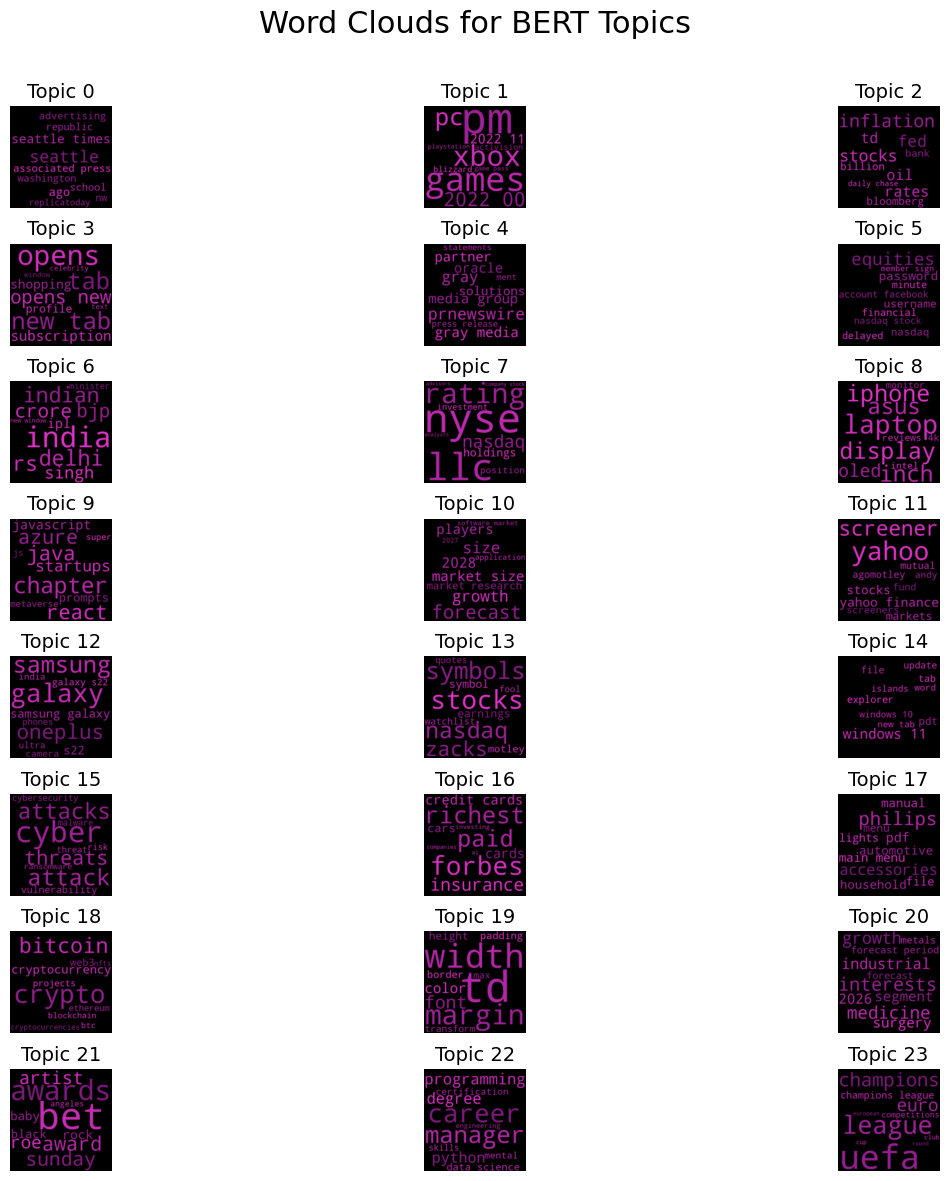

In [59]:
# Word clouds for BERT topics
bert_wordcloud_fig = create_bert_topic_wordclouds(topic_model)
plt.savefig('bert_topic_wordclouds.png', dpi=300, bbox_inches='tight')
plt.show()

### __BERTopic - Choosing the Number of Topics:__

__Topic Count Selection:__
BERTopic does not require predefining the number of topics. Instead, it uses HDBSCAN clustering to automatically determine the number of topics based on the density of embeddings in the reduced-dimensional space.
The number of topics is determined dynamically based on the clustering results.

__Final Number of Topics:__
After running BERTopic, 23 topics were identified. However, for analysis, only the top 9 topics would be considered to focus on the most meaningful clusters.

__Other Hyperparameters:__
1. Embedding Model: SentenceTransformer("thenlper/gte-small") was used to generate dense embeddings for the text.
2. Dimensionality Reduction: UMAP was used with n_components=10 and min_dist=0.1 to reduce the embedding dimensions.
3. Clustering: HDBSCAN was used with min_cluster_size=32 to group similar embeddings into topics.
Vectorizer: A CountVectorizer was used with ngram_range=(1, 2) and max_features=3000 to extract topic words.

__Visualization Used:__
Topic Visualization Plot: Displayed the topics in a 2D space, showing their distribution and overlap.
Word Clouds: Word clouds were generated for each topic to visualize the most important words contributing to each cluster.

# **Model Evaluation**

In [68]:
lda_labels = {
    0: "Product Features and Launches",
    1: "E-commerce and Market Trends",
    2: "User Interface and Notifications",
    3: "User Behavior and Preferences",
    4: "Community and Membership",
    5: "Technology and Business Trends",
    6: "Financial Tools and Analytics",
    7: "Workplace and Social Dynamics",
    8: "Stock Market and Financial Reports"
}

In [69]:
# Adjust pandas display options
pd.set_option('display.max_colwidth', None)

In [70]:
# Build the DataFrame
lda_label_df = pd.DataFrame({
    "Topic ID": list(lda_labels.keys())
})

# Add top 10 words for each topic
top_words = []
for topic_id in lda_label_df["Topic ID"]:
    words = [word for word, _ in model.show_topic(topic_id, topn=10)]
    top_words.append(", ".join(words))

lda_label_df["Top Words"] = top_words
lda_label_df["Label"] = list(lda_labels.values())

# Set "Topic ID" as the index
lda_label_df.set_index("Topic ID", inplace=True)

# Display the DataFrame
display(lda_label_df)

,Top Words,Label
Topic ID,,
0,"feature, look, rate, sale, come, launch, need, add, tv, expect",Product Features and Launches
1,"search_shopping, save_screeneretf, spark, sensor, selection, trend_activesstock, screeneretf, panel, recession_fear, affiliate_commission",E-commerce and Market Trends
2,"pm, message, view, account, sign, password, article, datum, profile, send",User Interface and Notifications
3,"use, site, website, support, experience, web, phone, page, cookie, find",User Behavior and Preferences
4,"provide, information, visit, position, member, environment, register, center, activity, registration",Community and Membership
5,"technology, business, release, transform, platform, datum, press, content, cloud, software",Technology and Business Trends
6,"search_shopping, save_screeneretf, spark, sensor, selection, trend_activesstock, screeneretf, panel, recession_fear, affiliate_commission",Financial Tools and Analytics
7,"hour, game, people, right, case, go, employee, win, thing, child",Workplace and Social Dynamics
8,"stock, price, quarter, report, investor, earning, research, trade, revenue, rise",Stock Market and Financial Reports


In [64]:
bertopic_words = []
for topic_id in range(9):
    words = [word for word, _ in topic_model.get_topic(topic_id)[:10]]
    bertopic_words.append(", ".join(words))

In [65]:
bertopic_words

['seattle, seattle times, ago, advertising, associated press, school, republic, washington, nw, replicatoday',
 'pm, games, xbox, pc, 2022 00, 2022 11, activision, blizzard, playstation, game pass',
 'inflation, stocks, fed, rates, oil, td, bloomberg, billion, bank, daily chase',
 'opens, new tab, tab, opens new, subscription, shopping, profile, celebrity, text, window',
 'prnewswire, gray, gray media, media group, partner, oracle, solutions, press release, ment, statements',
 'equities, password, username, nasdaq, financial, minute, delayed, nasdaq stock, account facebook, member sign',
 'india, delhi, indian, rs, crore, bjp, singh, ipl, minister, new window',
 'nyse, llc, rating, nasdaq, holdings, position, investment, company stock, advisors, analysts',
 'laptop, iphone, display, inch, asus, oled, reviews, 4k, monitor, intel']

In [66]:
bertopic_labels = {
    0: "Seattle News and Politics",
    1: "Gaming and Console News",
    2: "Global Financial Markets",
    3: "E-commerce and Subscriptions",
    4: "Corporate and Press Releases",
    5: "Nasdaq and Financial Updates",
    6: "Indian Politics and Economy",
    7: "Stock Market and Investments",
    8: "Consumer Electronics and Reviews"
}

In [67]:
bertopic_df = pd.DataFrame({
    "Topic ID": list(bertopic_labels.keys()),
    "Top Words": bertopic_words,
    "Label": list(bertopic_labels.values())
}).set_index("Topic ID")

display(bertopic_df)

,Top Words,Label
Topic ID,,
0,"seattle, seattle times, ago, advertising, associated press, school, republic, washington, nw, replicatoday",Seattle News and Politics
1,"pm, games, xbox, pc, 2022 00, 2022 11, activision, blizzard, playstation, game pass",Gaming and Console News
2,"inflation, stocks, fed, rates, oil, td, bloomberg, billion, bank, daily chase",Global Financial Markets
3,"opens, new tab, tab, opens new, subscription, shopping, profile, celebrity, text, window",E-commerce and Subscriptions
4,"prnewswire, gray, gray media, media group, partner, oracle, solutions, press release, ment, statements",Corporate and Press Releases
5,"equities, password, username, nasdaq, financial, minute, delayed, nasdaq stock, account facebook, member sign",Nasdaq and Financial Updates
6,"india, delhi, indian, rs, crore, bjp, singh, ipl, minister, new window",Indian Politics and Economy
7,"nyse, llc, rating, nasdaq, holdings, position, investment, company stock, advisors, analysts",Stock Market and Investments
8,"laptop, iphone, display, inch, asus, oled, reviews, 4k, monitor, intel",Consumer Electronics and Reviews


# **Analysis**

In [3]:
print("\nComparison between LDA and BERTopic:")
print(f"1. Number of topics detected:")
print(f"   - LDA: 20 topics")
print(f"   - BERTopic: 23 topics")

print("\n2. Document distribution across topics:")
print("   - LDA: Distributed across all topics")
print("   - BERTopic: Some documents classified as outliers")

print("\n3. Topic interpretability:")
print("   - LDA: Topics can be more difficult to interpret due to bag-of-words approach")
print("   - BERTopic: Topics often more coherent due to contextual embeddings")

print("\n4. Hyperparameter choices:")
print("   - LDA: Need to specify number of topics in advance")
print("   - BERTopic: Can automatically determine number of topics")

print("\n5. Semantic understanding:")
print("   - LDA: Based on word co-occurrence statistics")
print("   - BERTopic: Based on contextual word embeddings from transformer models")



Comparison between LDA and BERTopic:
1. Number of topics detected:
   - LDA: 20 topics
   - BERTopic: 23 topics

2. Document distribution across topics:
   - LDA: Distributed across all topics
   - BERTopic: Some documents classified as outliers

3. Topic interpretability:
   - LDA: Topics can be more difficult to interpret due to bag-of-words approach
   - BERTopic: Topics often more coherent due to contextual embeddings

4. Hyperparameter choices:
   - LDA: Need to specify number of topics in advance
   - BERTopic: Can automatically determine number of topics

5. Semantic understanding:
   - LDA: Based on word co-occurrence statistics
   - BERTopic: Based on contextual word embeddings from transformer models


There are several key differences between the LDA and BERTopic models when applied to the news article data:

1. Topic Detection and Flexibility: 
LDA required us to predefine the number of topics, whereas BERTopic automatically identified 23 topics from the data. This demonstrates BERTopic's adaptability to the  structure of the corpus without requiring manual specification. The higher number of topics discovered by BERTopic suggests it may be capturing more fine-grained thematic distinctions in the news articles.

2. Document Classification Strategy: 
LDA assigned every document to a probability distribution across all topics, meaning each document had some association with each topic. In contrast, BERTopic's clustering-based approach allowed it to classify some documents as outliers that don't fit well into the discovered topic structure. This creates a more selective topic assignment but potentially leaves some documents uncategorized.

3. Topic Coherence and Interpretability: 
BERTopic produced more coherent topics due to its use of contextual embeddings from transformer models. These topics were generally easier to interpret as they captured meaningful relationships between words. LDA's BOW approach resulted in topics that were more challenging to interpret clearly.

4. Semantic Understanding:
LDA operates on simple word co-occurrence patterns, treating words as independent units without considering their context. BERTopic leverages pre-trained transformer models that capture rich contextual information and semantic relationships between words, allowing it to group thematically related content even when different terminology is used.

5. Practical Implications: 
For news article analysis, BERTopic offers advantages in discovering topics with greater  coherence. However, LDA's simpler approach might be more computationally efficient for larger datasets. The choice between methods depends on wheater interpretability, granularity of topics or computational efficiency is prioritized for a specific application.

BERTopic demonstrated superior performance in terms of topic coherence and semantic understanding, making it particularly valuable for complex text like news articles where contextual understanding is important. However, LDA's simplicity and full document classification may be preferable in certain applications where computational efficiency or complete topic assignment is required.